## skpro introduction notebook

**Set-up instructions:** On binder, this should run out-of-the-box.

To run this notebook as intended, ensure that `skpro` with basic dependency requirements is installed in your python environment.

`skpro` provides `scikit-learn`-like, `scikit-base` compatible interfaces to:

* tabular **supervised regressors with probabilistic prediction modes** - interval, quantile and distribution predictions
* **performance metrics to evaluate probabilistic predictions**, e.g., pinball loss, empirical coverage, CRPS
* **reductions** to turn non-probabilistic, `scikit-learn` regressors into probabilistic `skpro` regressors, such as bootstrap or conformal
* tools for building **pipelines and composite machine learning models**, including tuning via probabilistic performance metrics
* symbolic an lazy **probability distributions** with a value domain of `pandas.DataFrame`-s and a `pandas`-like interface

**Section 1** provides an overview of common **probabilistic supervised regression workflows** supported by `skpro`.

**Section 2** gives an introduction to the different **prediction modes, performance metrics, and benchmarking tools**.

**Section 3** discusses **advanced composition patterns**, including various ways to add probabilistic capability to any `sklearn` regressor, pipeline building, tuning, ensembling.

**Section 4** gives an introduction to how to write **custom estimators** compliant with the `skpro` interface.

In [ ]:
import warnings

# import numpy as np
# import pandas as pd

# hide warnings
warnings.filterwarnings("ignore")

## 1. Basic probabilistic supervised regression workflows <a class="anchor" id="chapter1"></a>

`skpro` revolves around supervised probabilistic regressors:

* `fit(X, y)` with tabular features `X`, labels `y`, same rows, both `pd.DataFrame`
* `predict_interval(X_test)` for interval predictions of labels
* `predict_quantiles(X_test)` for quantile predictions of labels
* `predict_var(X_test)` for variance predictions of labels
* `predict(X_test)` for mean predictions
* `predict_proba(X_test)` for distributional prediction

### 1.1 basic deployment workflow

`skpro` regressors are used via `fit` then `predict_proba` etc.

Same as `sklearn` regressors - `X` and `y` should be `pd.DataFrame` (`numpy` is also ok but not recommended)

In [ ]:

from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.regression.residual import ResidualDouble

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_new, y_train, _ = train_test_split(X, y)

# step 2: specifying the regressor
# example - random forest for mean prediction
# linear regression for variance prediction
reg_mean = RandomForestRegressor()
reg_resid = LinearRegression()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# step 3: fitting the model to training data
reg_proba.fit(X_train, y_train)

# step 4: predicting labels on new data

# probabilistic prediction modes - pick any or multiple
# we show the return types in detail below

# full distribution prediction
y_pred_proba = reg_proba.predict_proba(X_new)

# interval prediction
y_pred_interval = reg_proba.predict_interval(X_new, coverage=0.9)

# quantile prediction
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=[0.05, 0.5, 0.95])

# variance prediction
y_pred_var = reg_proba.predict_var(X_new)

# mean prediction is same as "classical" sklearn predict, also available
y_pred_mean = reg_proba.predict(X_new)

### 1.1.1 distribution predictions

`y_pred_proba` is an `skpro` distribution - it has index and columns like `pd.DataFrame`

"we predict that true labels are distributed according to `y_pred_proba`"

(here: distribution marginal by row/columns)

In [ ]:
y_pred_proba = reg_proba.predict_proba(X_new)
y_pred_proba

`skpro` distribution objects are pandas-like

In [ ]:
y_pred_proba.shape

In [ ]:
y_pred_proba.index  # same index as X_new

In [ ]:
y_pred_proba.columns  # same columns as X_new

distribution objects have `sample` and methods such as `mean`, `var`:

In [ ]:
y_pred_proba.sample().head()

In [ ]:
y_pred_proba.mean().head()

In [ ]:
y_pred_proba.var().head()

### 1.1.2 interval predictions

interval prediction `y_pred_interval` is a `pd.DataFrame`:

* rows are the same as `X_new`
* columns indicate variables, nominal coverage, and bottom/upper bound

"we predict that value in row falls between bottom/upper with 90% chance"

In [ ]:
y_pred_interval = reg_proba.predict_interval(X_new, coverage=0.9)
y_pred_interval.head()

### 1.1.3 quantile predictions

quantile prediction `y_pred_quantiles` is a `pd.DataFrame`:

* rows are the same as `X_new`
* columns indicate variables, quantile points

"we predict the 5%, 50%, 95% quantile points for the row to be here"

In [ ]:
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=[0.05, 0.5, 0.95])
y_pred_quantiles.head()

### 1.1.4 mean and variance predictions

mean and variance predictions `y_pred_mean`, `y_pred_var` are `pd.DataFrame`-s:

* rows are the same as `X_new`
* columns are the same as `X_new`

entries are predictive mean and variance in row/column

In [ ]:
y_pred_mean = reg_proba.predict(X_new)
y_pred_var = reg_proba.predict_var(X_new)

In [ ]:
y_pred_mean.head()

In [ ]:
y_pred_var.head()

this is the same as taking the distribution prediction and taking mean/variance

(for distribution objects that estimate these precisely)

In [ ]:
y_pred_proba.mean().head()

In [ ]:
y_pred_proba.var().head()

### 1.2 simple evaluation workflow for probabilistic predictions

for simple evaluation:

1. split the data into train/test set
2. make predictions of either type for test features
3. compute metric on test set, comparing test predictions to hend out test labels

Note:

* metrics will compare tabular ground truth to probabilistic prediction
* the metric will needs to be of a compatible type, e.g., for proba predictions

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.metrics import CRPS
from skpro.regression.residual import ResidualDouble

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# step 2: specifying the regressor
# example - linear regression for mean prediction
# random forest for variance prediction
reg_mean = LinearRegression()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# step 3: fitting the model to training data
reg_proba.fit(X_train, y_train)

# step 4: predicting labels on new data
y_pred_proba = reg_proba.predict_proba(X_test)

# step 5: specifying evaluation metric
metric = CRPS()

# step 6: evaluat metric, compare predictions to actuals
metric(y_test, y_pred_proba)

how do we know that metric is of right type? Via `scitype:y_pred` tag

In [ ]:
metric.get_tags()
# scitype:y_pred is pred_proba - for proba predictions

how do we find metrics for a prediction type?

In [ ]:
from skpro.registry import all_objects

all_objects("metric", as_dataframe=True, return_tags="scitype:y_pred")

extra note: quantile metrics can be applied to interval predictions as well

more details on metrics below

### 1.2.1 diagnostic visualisations

some useful diagnostic visualisations: variants of crossplots for probabilistic predictions

A. crossplot ground truth vs prediction intervals.

Works with both proba and interval predictions.

What to look for: intervals shouhld cut through the x = y line (green points)

In [ ]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

In [ ]:
from skpro.utils.plotting import plot_crossplot_interval

y_pred_interval = reg_proba.predict_interval(X_test, coverage=0.9)
plot_crossplot_interval(y_test, y_pred_interval)

B. crossplot residuals vs predictive standard deviation

Works with both proba and variance predictions.

What to look for: should be close to a line, high linear correlation

In [ ]:
from skpro.utils.plotting import plot_crossplot_std

plot_crossplot_std(y_test, y_pred_proba)

In [ ]:
from skpro.utils.plotting import plot_crossplot_std

y_pred_var = reg_proba.predict_var(X_test)
plot_crossplot_std(y_test, y_pred_var)

C. crossplot ground truth vs loss values

Loss and prediction type should agree.

What to look for: association between accuracy and ground truth value

Diagnostic of which values we can predict more accurately, e.g., to inform modelling

In [ ]:
from skpro.utils.plotting import plot_crossplot_loss

crps_metric = CRPS()
plot_crossplot_loss(y, y_pred_proba, crps_metric)

### 1.3 searching for probabilistic regressors and metrics

all objects in `skpro` are indexed via the `registry` utility `all_objects`.

To find probabilistic supervised regressors, use `all_objects` with the type `regressor_proba`:

In [ ]:
from skpro.registry import all_objects

all_objects("regressor_proba", as_dataframe=True).head()

a full list can also be found in the online API reference.

## 3. Advanced composition patterns <a class="anchor" id="chapter3"></a>

we introduce a number of composition patterns available in `skpro`:

* reducer-wrappers that turn `sklearn` regressors into probabilistic ones
* pipelines of `sklearn` transformers with `skpro` regressors
* tuning `skpro` probabilistic regressors via grid/random search, minimizing a probabilistic metric
* ensembling multiple `skpro` probabilistic regressors

data used in this section:

In [22]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

### 3.1 Reducers to turn `sklearn` regressors probabilistic <a class="anchor" id="section3_1"></a>

there are many common algorithms that turn a non-probabilistic tabular regressor probabilistic

formally, this is a type of "reduction" - of probabilistic supervised tabular to non-probabilistic supervised tabular

Examples:

* predicting variance equal to training residual variance - `ResidualDouble` with standard settings
    * or other unconditional distribution estimate for residuals
* "squaring the residual" two-step prediction - `ResidualDouble`
* boostrap prediction intervals - `BootstrapRegressor`
* conformal prediction intervals - contributions appreciated :-)
* natural gradient boosting aka NGBoost - contributions appreciated :-)

### 3.1.1 constant variance prediction <a class="anchor" id="section3_1_1"></a>

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# estimator specification - use any sklearn regressor for reg_mean
reg_mean = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, cv=KFold(5))
# cv is used to estimate out-of-sample residual variance via 5-fold CV

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

TypeError: Cannot clone object 'None' (type <class 'NoneType'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

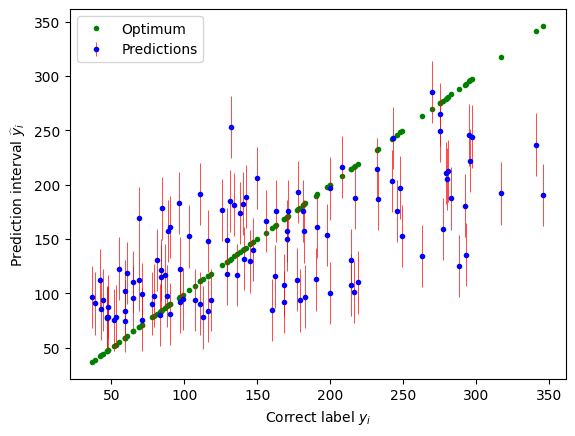

In [26]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)